In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import KeyFunctions as me
import skopt as skopt
import warnings

warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")

RandState = 117

In [2]:
from sklearn.model_selection import train_test_split

#Import Full R6g Dataset
df, labels = me.ConstructCombinedDataset()
df = me.BaselineCorrection(me.BaselineCorrection(df))

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.8)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()
display(labels)

['10-5', '10-6', '10-7', '10-8', '10-9', '10-11', '10-14', '10-16']

In [3]:
#Scale Dataset

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

Scale = StandardScaler()

X_tn = Scale.fit_transform(X_tn)
X_tt = Scale.transform(X_tt)

In [4]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tn, y_tn)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tn, y_tn)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.63157895, 0.89473684, 0.77777778, 0.88888889, 0.77777778])

0.7941520467836256

0.13434052467346191

In [5]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, 472, 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = 5)
RFBS = Bayes.fit(X_tn, y_tn)
RFC = RFBS.best_estimator_
SC_RFC = RFC.fit(X_tn, y_tn)


display(RFBS.best_params_)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'entropy'),
             ('max_features', 49),
             ('n_estimators', 92)])

0.868421052631579

0.05795082639456135

0.2866940498352051

In [6]:
from sklearn.metrics import confusion_matrix
y_pred = RFBS.predict(X_tt)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMNT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 3, Predicted: 10-14; Actual: 10-8'

'Total Predictions: 22'

'Total Errors: 1'

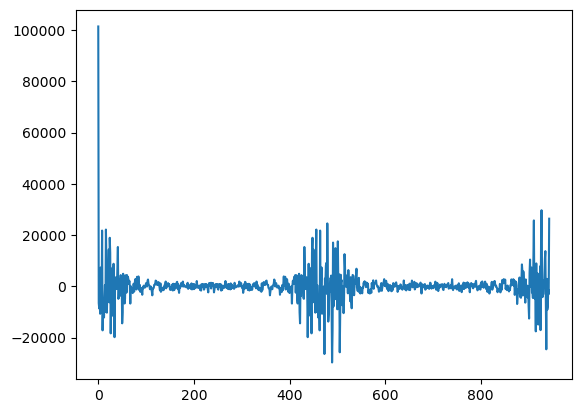

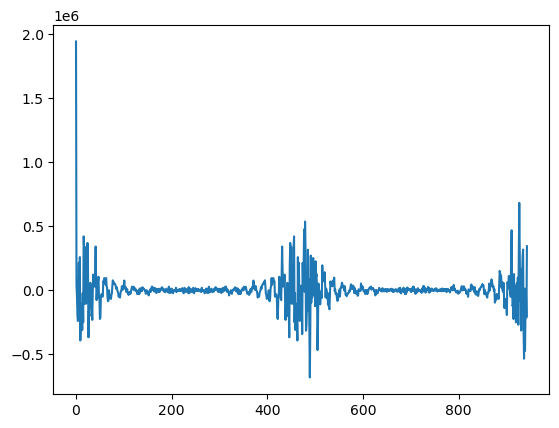

In [7]:
#Apply Fourier Transform to Training and Testing Data
#Fourier Transform Performs Best Without Scaling
X_tt = test.to_numpy()
X_tn = train.to_numpy()

X_tnf = np.fft.fft(X_tn)
X_ttf = np.fft.fft(X_tt)

#Data is stored as columns of all real values followed by columns of all imaginary values.
X_tnf = np.append(np.real(X_tnf), np.imag(X_tnf), axis = 1)
X_ttf = np.append(np.real(X_ttf), np.imag(X_ttf), axis = 1)

plt.figure()
plt.plot(X_tnf[1, :])
plt.figure()
plt.plot(X_tnf[7, :]);

In [8]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score

df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tnf, y_tn)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tnf, y_tn)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.68421053, 0.89473684, 0.72222222, 0.88888889, 0.77777778])

0.7935672514619883

0.15998373031616211

In [9]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, np.shape(X_tnf)[1], 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = 5)
RFBS = Bayes.fit(X_tnf, y_tn)
RFC = RFBS.best_estimator_
FT_RFC = RFC.fit(X_tnf, y_tn)

display(RFBS.best_params_)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'entropy'),
             ('max_features', 31),
             ('n_estimators', 31)])

0.8146198830409357

0.05707674239792545

0.08168363571166992

In [10]:
y_pred = RFBS.predict(X_ttf)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMFT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 2, Predicted: 10-11; Actual: 10-9'

'Incorrect Prediction at 3, Predicted: 10-9; Actual: 10-8'

'Incorrect Prediction at 17, Predicted: 10-9; Actual: 10-14'

'Total Predictions: 22'

'Total Errors: 3'

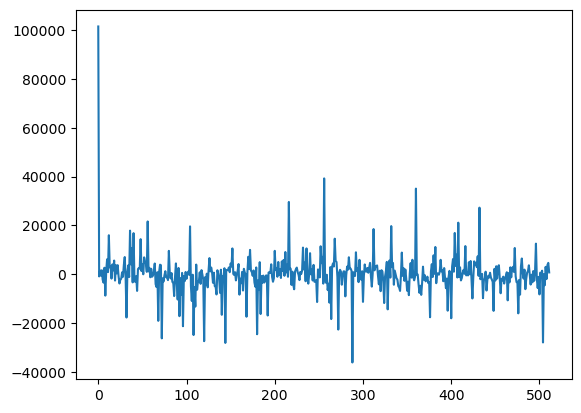

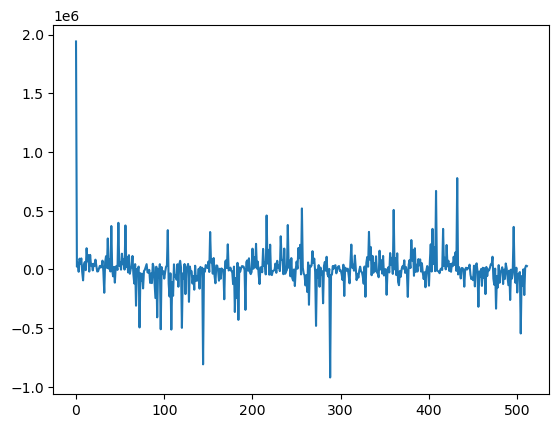

In [11]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht
X_tt = test.to_numpy()
X_tn = train.to_numpy()

X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tn)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)

plt.figure()
plt.plot(X_tnh[1, :])
plt.figure()
plt.plot(X_tnh[7, :]);

In [12]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score

df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tnh, y_tn)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tnh, y_tn)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.73684211, 0.84210526, 0.72222222, 0.88888889, 0.72222222])

0.7824561403508772

0.23045907020568848

In [13]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, np.shape(X_tnh)[1], 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = 5)
RFBS = Bayes.fit(X_tnh, y_tn)
RFC = RFBS.best_estimator_
HT_RFC = RFC.fit(X_tnh, y_tn)

display(RFBS.best_params_)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'entropy'),
             ('max_features', 289),
             ('n_estimators', 22)])

0.8152046783625732

0.064338117143743

0.38459348678588867

In [14]:
y_pred = RFBS.predict(X_tth)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMHT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 2, Predicted: 10-16; Actual: 10-9'

'Incorrect Prediction at 3, Predicted: 10-9; Actual: 10-8'

'Incorrect Prediction at 4, Predicted: 10-14; Actual: 10-9'

'Incorrect Prediction at 16, Predicted: 10-14; Actual: 10-16'

'Total Predictions: 22'

'Total Errors: 4'

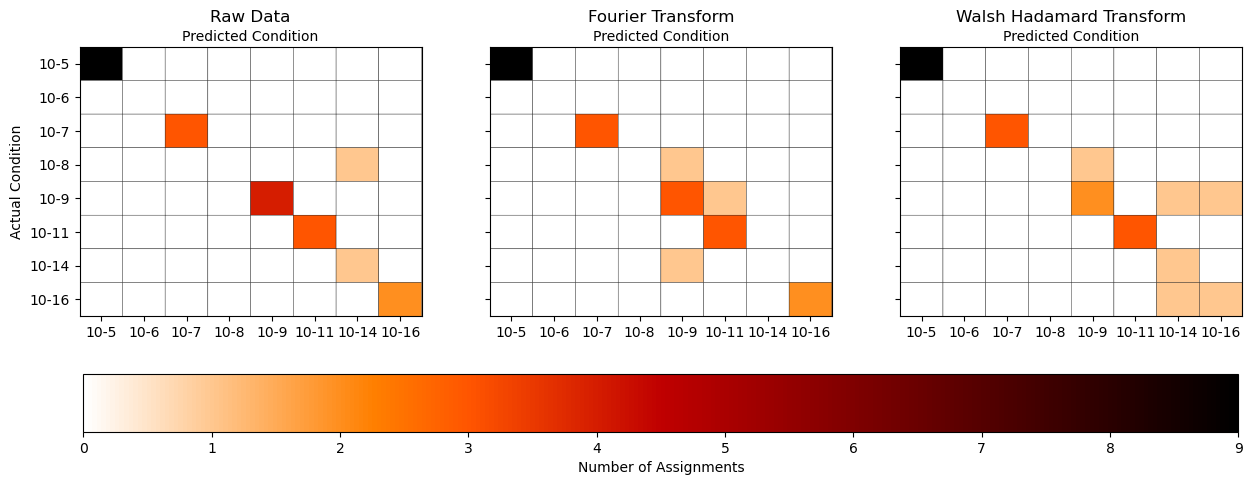

In [15]:

fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMNT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');

<Figure size 640x480 with 0 Axes>

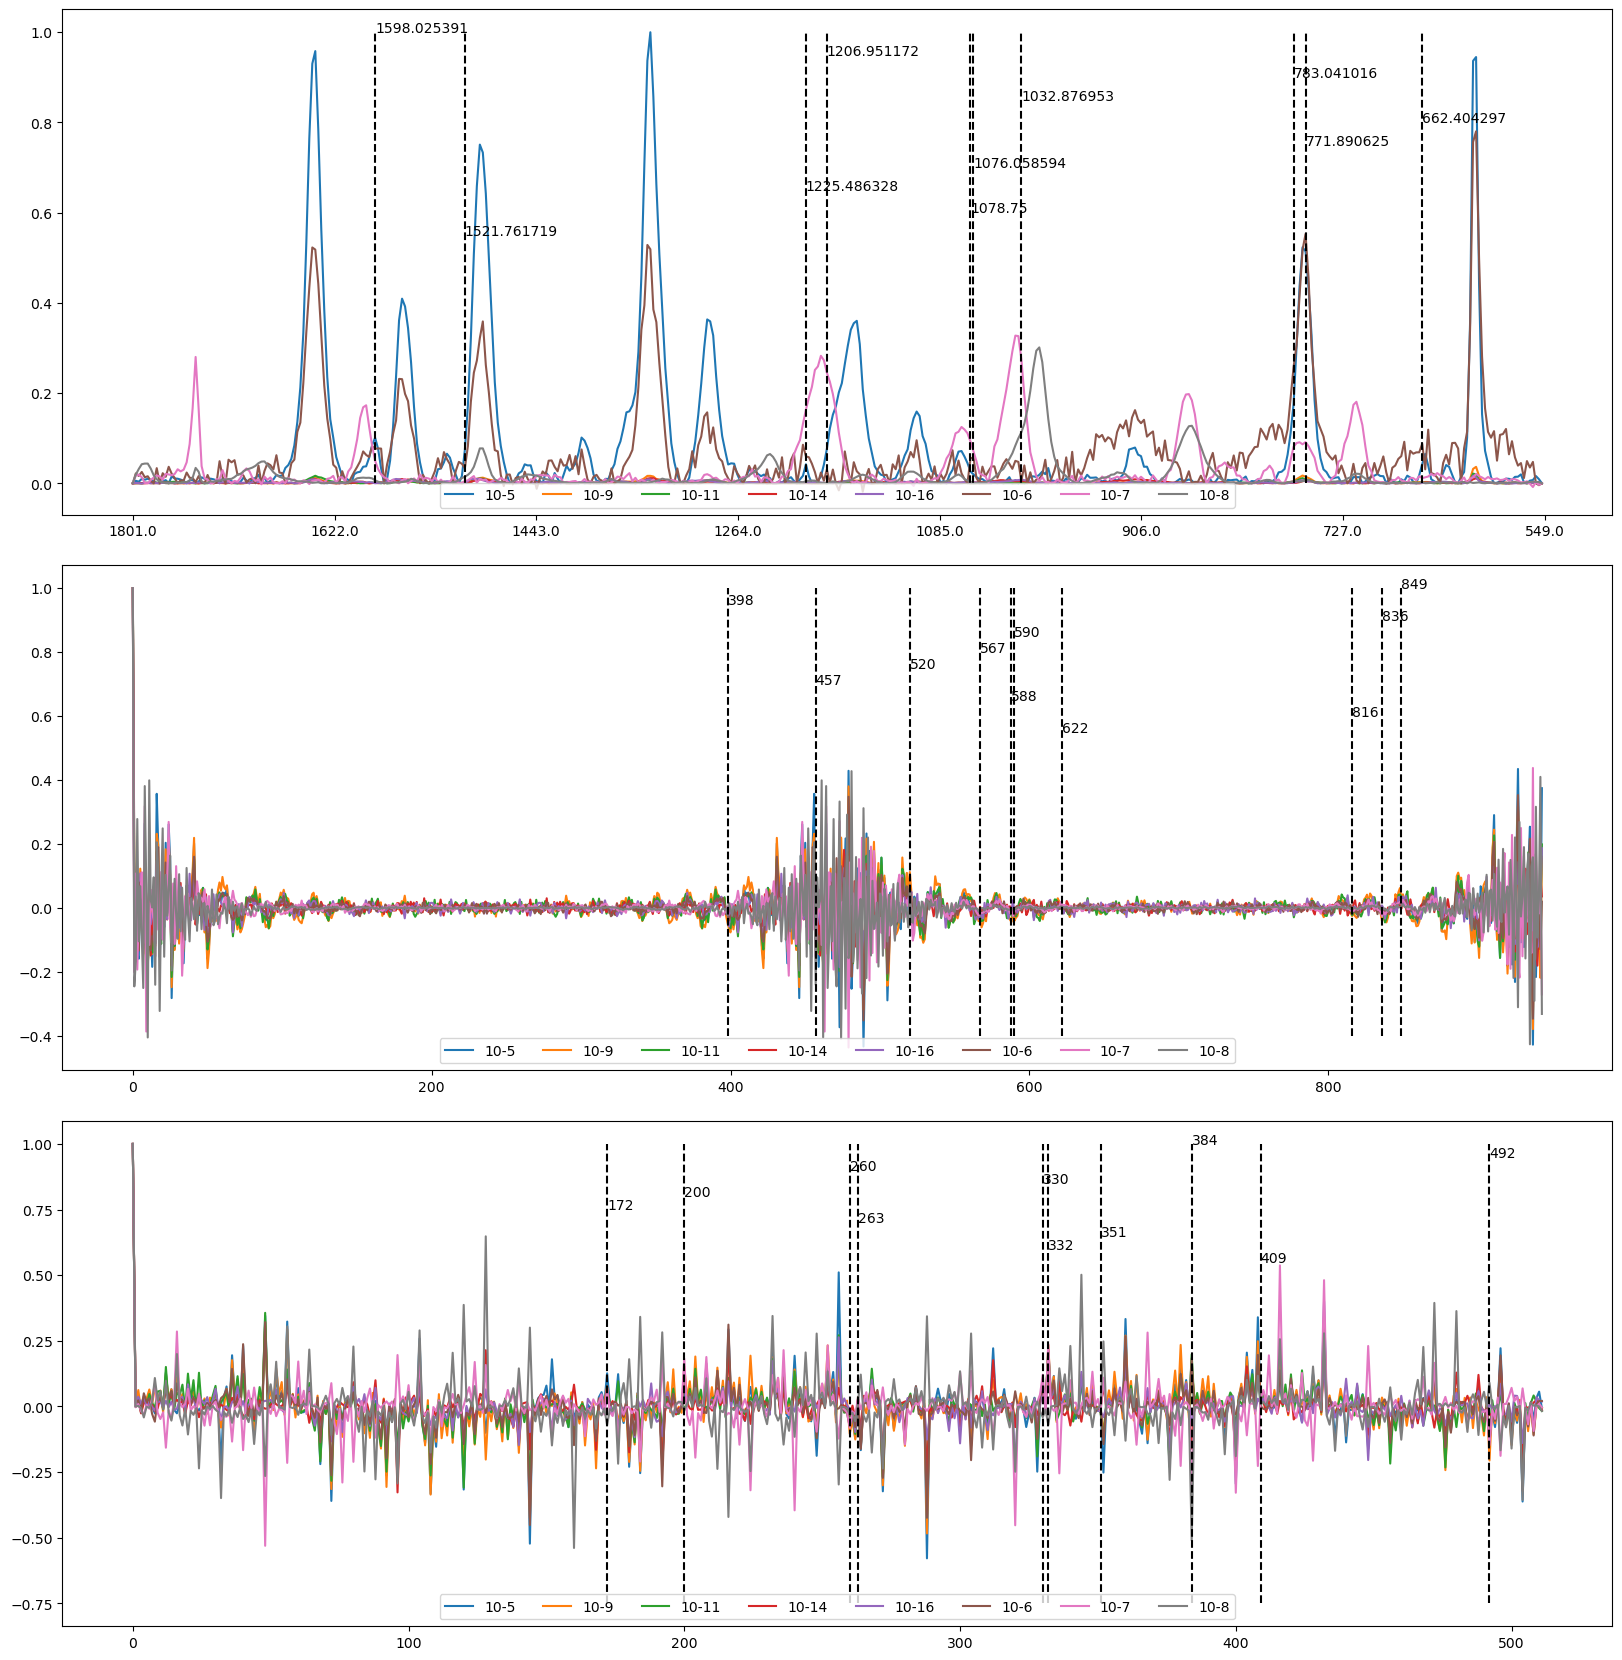

In [16]:
from sklearn.inspection import permutation_importance
import matplotlib.ticker as mticker

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.tight_layout()

fig, ax = plt.subplots(3, 1, figsize = [20, 21])
plt.subplots_adjust(hspace = 0.1, wspace = 0)

SC_imp = pd.Series(SC_RFC.feature_importances_)
FT_imp = pd.Series(FT_RFC.feature_importances_)
HT_imp = pd.Series(HT_RFC.feature_importances_)

plotted = []
mx_graph = 0
for ind, row in df.iterrows():
    if ind not in plotted:
        if max(row) > mx_graph:
            mx_graph = max(row)
        plotted.append(ind)

plotted =[]

for ind, row in df.iterrows():
    if ind not in plotted:
        row = row/mx_graph
        ax[0].plot(row)
        plotted.append(ind)

ticks_loc = np.linspace(0, np.shape(df)[1], 8)
ax[0].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ticklbls = np.linspace(max(df.columns.astype(float)), min(df.columns.astype(float)), 8)
ticklbls = np.round(ticklbls)
ax[0].set_xticklabels(ticklbls)

SC_imp.sort_values(ascending = False, inplace = True)
SC_keypeaks = SC_imp.iloc[0:10]
kp_lbls = df.columns[SC_keypeaks.index].values
ax[0].vlines(SC_keypeaks.index, ymin = 0, ymax= 1, color = 'k', linestyle = 'dashed', label = 'Highest Importance Peaks')

for ind, val in np.ndenumerate(kp_lbls):
    x = SC_keypeaks.index[ind[0]]
    ax[0].annotate(val, xy = (x, 1-ind[0]*0.05))
    
ax[0].legend(plotted, loc = 8, ncol = len(plotted))

##
plotted = []
for ind, row in df.iterrows():
    if ind not in plotted:
        ft_row = np.fft.fft(row)
        ft_row = np.append(np.real(ft_row), np.imag(ft_row))
        ft_row = ft_row/max(ft_row)
        ax[1].plot(ft_row)
        plotted.append(ind)


FT_imp.sort_values(ascending = False, inplace = True)
FT_keypeaks = FT_imp.iloc[0:10]
kp_lbls = FT_keypeaks.index.values
ax[1].vlines(FT_keypeaks.index, ymin = -0.4, ymax= 1, color = 'k', linestyle = 'dashed', label = 'Highest Importance Peaks')

for ind, val in np.ndenumerate(kp_lbls):
    x = FT_keypeaks.index[ind[0]]
    ax[1].annotate(val, xy = (x, 1-ind[0]*0.05))

ax[1].legend(plotted, loc = 8, ncol = len(plotted))

##
plotted = []
for ind, row in df.iterrows():
    if ind not in plotted:
        ht_row = np.array(fwht(row))
        ht_row = ht_row/max(ht_row)
        ax[2].plot(ht_row)
        plotted.append(ind)


HT_imp.sort_values(ascending = False, inplace = True)
HT_keypeaks = HT_imp.iloc[0:10]
kp_lbls = HT_keypeaks.index.values
ax[2].vlines(HT_keypeaks.index, ymin = -0.75, ymax= 1, color = 'k', linestyle = 'dashed', label = 'Highest Importance Peaks')

for ind, val in np.ndenumerate(kp_lbls):
    x = HT_keypeaks.index[ind[0]]
    ax[2].annotate(val, xy = (x, 1-ind[0]*0.05))

ax[2].legend(plotted, loc = 8, ncol = len(plotted))